# Práctica Final
# Detección de implicación textual en español - Aitana Villaplana Moreno

Para esta práctica final se ha seleccionado el tema de detección de implicación textual en español, ya que resulta un tema más interesante, y algo distinto a lo realizado en las anteriores prácticas sobre Sentiment Analysis, además de tener mayor número de posibles aplicaciones.

En esta práctica se abordarán los temas vistos anteriormente, preprocesamiento y representación de los datos, entrenamiento de modelos de ML como baseline, además de realizar entrenamientos y testeos con varios conjuntos de datos para realizar transfer learning.

Se irán explorando también todo tipo de modelos de DL, y distintas arquitecturas.


##1. Importación de librerías, carga y visualización de los datos
En primer lugar se importarán las librerías necesarias para el desarrollo de la práctica. En segundo lugar se cargarán los cuatro ficheros del conjunto de datos, subidos la carpeta del drive, el conjunto de entrenamiento (training) y el conjunto de validación (test).

In [7]:
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Se descargan los datasets y se visualizan las 10 primeras filas.

In [8]:
training_set = pd.read_csv("/content/drive/My Drive/sick_es_train.csv", quotechar='"', header=0, sep=",")
test_set = pd.read_csv("/content/drive/My Drive/sick_es_test.csv", quotechar='"', header=0, sep=",")

dataset = pd.concat([training_set,test_set])
training_set.head(10)

,pair_ID,translated_A,translated_B,entailment_label
0,2886,Una mujer toca una flauta,La mujer no toca la flauta,CONTRADICTION
1,4940,Un oficial está hablando con los reclutas.,Los reclutas le ladran al oficial militar,NEUTRAL
2,3307,Un aeroplano vuela por el aire,Un avión está estacionado en tierra.,CONTRADICTION
3,1891,Una persona canta y toca la guitarra.,Un hombre toca apasionadamente la guitarra,NEUTRAL
4,129,Un anciano está sentado en un campo.,Un hombre está sentado en un campo,ENTAILMENT
5,874,Una pista de patinaje sobre hielo colocada al ...,No hay mucha gente en el parque de patinaje so...,CONTRADICTION
6,1006,Un niño con una camisa roja está detrás de una...,Un niño está parado frente al edificio azul en...,NEUTRAL
7,7459,Un surfista está montando la ola,Un jinete está surfeando la ola,ENTAILMENT
8,7896,Un coche de carreras blanco atraviesa un charco.,Un vehículo de carreras blanco atraviesa un ch...,ENTAILMENT
9,7265,El hombre está haciendo un caballito en una bi...,Un hombre en bicicleta va en una sola rueda,ENTAILMENT


Como se puede observar, los datos están compuestos de dos frases, A y B, y la etiqueta hace referencia a la relación entre ambas frases.
CONTRADICTION para indicar contradicción, ENTAILMENT para indicar relación, y NEUTRAL para indicar que no hay relación. 

Por lo tanto estamos ante un problema de clasificación con 3 clases.

In [ ]:
not_entailment_dataset = dataset[(dataset['entailment_label'] != 'CONTRADICTION') & (dataset['entailment_label'] != 'NEUTRAL') & \
                                        (dataset['entailment_label'] != 'ENTAILMENT')]
print("Filas con un label incorrecto: ", not_entailment_dataset.shape[0])

Filas con un label incorrecto:  0


Comprobamos que no existen datos con labels incorrectas. Y sacamos la proporción de clases en los datos para saber si están balanceados.

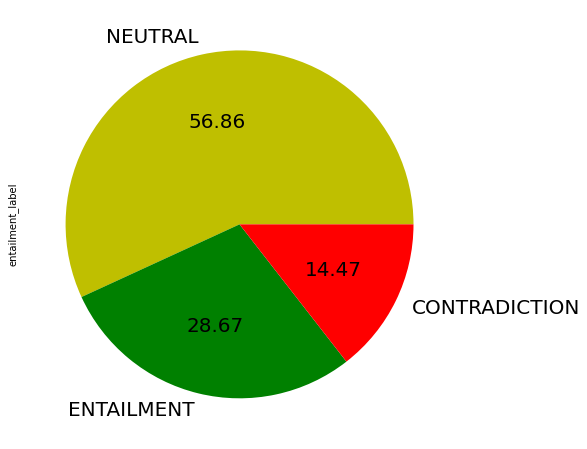

In [ ]:
dataset['entailment_label'].value_counts().plot(kind='pie', figsize=(10, 8), autopct='%.2f', fontsize=20, colors=['y', 'g', 'r'])

Como se observa en el gráfico, existe un desbalance entre las clases CONTRADICTION y NEUTRAL, ya que más de la mitad de los datos son de una misma clase. Esto puede suponer un problema a la hora de clasificar los datos.

A continuación se pre-procesa el texto, eliminando acentos y símbolos no alfanuméricos. También se han eliminado las stopwords, pero se han dejado las que indican negración (no y ni) ya que son vitales para algunos casos de contradicción.

In [10]:
import re

def process_text(text_serie):
    without_accents = text_serie.lower().replace("á", "a").replace("é", "e").replace("í", "i").replace("ó", "o").replace("ú", "u")
    alphanumeric_text = re.sub("[^0-9a-zA-Z]+", " ", without_accents) 
    tokens = alphanumeric_text.split()
    
    # Dejamos la negación
    stop_words = set(nltk.corpus.stopwords.words("spanish")) - set(["no", "ni"])
    tokens_without_stopwords = [token for token in tokens if token not in stop_words]
    
    return tokens_without_stopwords

dataset["translated_A_processed"] = dataset["translated_A"].apply(process_text)
dataset["translated_B_processed"] = dataset["translated_B"].apply(process_text)
dataset

,pair_ID,translated_A,translated_B,entailment_label,translated_A_processed,translated_B_processed
0,2886,Una mujer toca una flauta,La mujer no toca la flauta,CONTRADICTION,"[mujer, toca, flauta]","[mujer, no, toca, flauta]"
1,4940,Un oficial está hablando con los reclutas.,Los reclutas le ladran al oficial militar,NEUTRAL,"[oficial, hablando, reclutas]","[reclutas, ladran, oficial, militar]"
2,3307,Un aeroplano vuela por el aire,Un avión está estacionado en tierra.,CONTRADICTION,"[aeroplano, vuela, aire]","[avion, estacionado, tierra]"
3,1891,Una persona canta y toca la guitarra.,Un hombre toca apasionadamente la guitarra,NEUTRAL,"[persona, canta, toca, guitarra]","[hombre, toca, apasionadamente, guitarra]"
4,129,Un anciano está sentado en un campo.,Un hombre está sentado en un campo,ENTAILMENT,"[anciano, sentado, campo]","[hombre, sentado, campo]"
...,...,...,...,...,...,...
1963,3755,Un niño está mirando un calendario.,Un niño está destrozando un calendario,NEUTRAL,"[ni, mirando, calendario]","[ni, destrozando, calendario]"
1964,2003,El hombre está en el paseo con el caballo,El caballo está siendo montado por un hombre.,NEUTRAL,"[hombre, paseo, caballo]","[caballo, siendo, montado, hombre]"
1965,9532,Dos autos de carrera están en una carretera fr...,Dos autos para carreras están en una carretera...,ENTAILMENT,"[dos, autos, carrera, estan, carretera, frente...","[dos, autos, carreras, estan, carretera, frent..."
1966,6957,La música está a cargo de cuatro personas al a...,Cuatro personas están tocando música al aire l...,ENTAILMENT,"[musica, cargo, cuatro, personas, aire, libre]","[cuatro, personas, estan, tocando, musica, air..."


A continucación vamos a estudiar las palabras más frecuentes para cada clase del datatset.

In [ ]:
# Agrupación todos los tokens por clase
grouped_A = dataset.groupby("entailment_label").apply(lambda x: x["translated_A_processed"].sum())
grouped_B = dataset.groupby("entailment_label").apply(lambda x: x["translated_B_processed"].sum())
grouped_df = pd.DataFrame({"entailment_label": grouped_A.index, "translated_A_processed": grouped_A.values, "translated_B_processed": grouped_B.values})
grouped_df

,entailment_label,translated_A_processed,translated_B_processed
0,CONTRADICTION,"[mujer, toca, flauta, aeroplano, vuela, aire, ...","[mujer, no, toca, flauta, avion, estacionado, ..."
1,ENTAILMENT,"[anciano, sentado, campo, surfista, montando, ...","[hombre, sentado, campo, jinete, surfeando, ol..."
2,NEUTRAL,"[oficial, hablando, reclutas, persona, canta, ...","[reclutas, ladran, oficial, militar, hombre, t..."


La función `plot_most_frequent_words` muestra las 10 palabras más recuentes para una los datos de una label dada.

In [ ]:
def plot_most_frequent_words(tokens, label, n_most_frequent=10):
    from collections import Counter

    counter = Counter(tokens)
    keys = [x[0] for x in counter.most_common(n_most_frequent)]
    values = [x[1] for x in counter.most_common(n_most_frequent)]

    labels = {"CONTRADICTION": "red", "ENTAILMENT" : "green", "NEUTRAL": "yellow"}
    fig = plt.figure(figsize = (12, 6))
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.bar(keys, values, color=[labels[label]])
    plt.title("Palabras más frecuentes de implicación " + label, fontsize=20)

En primer lugar mostramos las palabras más frecuentes en la clase CONTRADICTION.

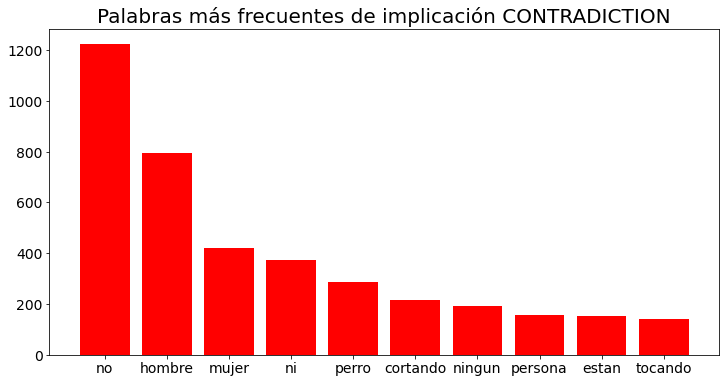

In [ ]:
contradiction_tokens = grouped_df[grouped_df['entailment_label'] == 'CONTRADICTION']['translated_A_processed'].values.tolist()[0] \
                     + grouped_df[grouped_df['entailment_label'] == 'CONTRADICTION']['translated_B_processed'].values.tolist()[0]
plot_most_frequent_words(contradiction_tokens, 'CONTRADICTION')

Se puede ver que la palabra más frecuente es "no", lo que puede ser debido a que al tratarse de una contradicción sea bastante utilizada. También está la palabra "ni", el resto de palabras ni aportan demasiado significado semántico.

Vamos a observar el resto de clases.

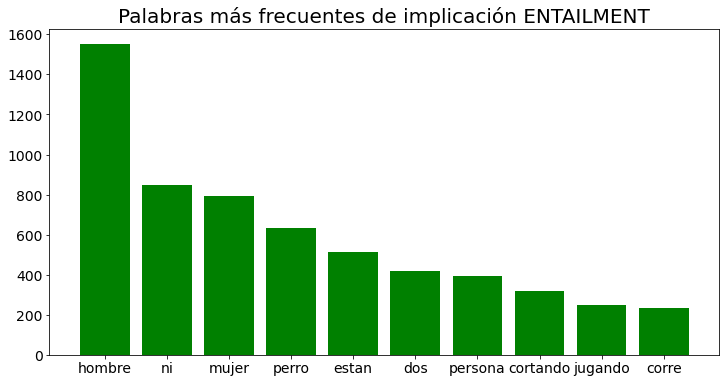

In [ ]:
entailment_tokens = grouped_df[grouped_df['entailment_label'] == 'ENTAILMENT']['translated_A_processed'].values.tolist()[0] \
                  + grouped_df[grouped_df['entailment_label'] == 'ENTAILMENT']['translated_B_processed'].values.tolist()[0]
plot_most_frequent_words(entailment_tokens, 'ENTAILMENT')

Las palabras que representan la clase de implicación, tampoco representan demasiado significado semántico, sin embargo aparece la palabra "ni" con mayor frecuencia que en el caso de contradicción, lo que indica que no tiene mucho peso en las contradicciones.

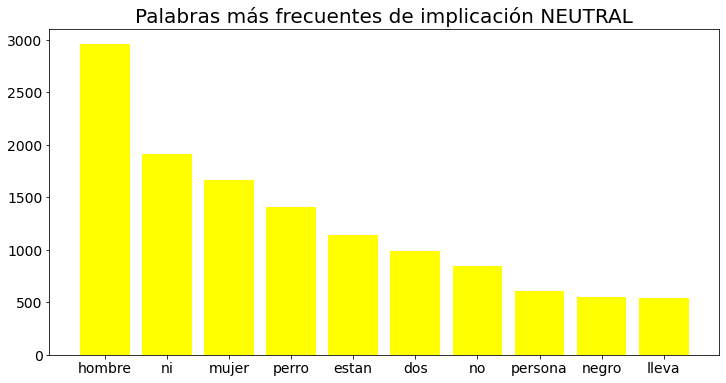

In [ ]:
neutral_tokens = grouped_df[grouped_df['entailment_label'] == 'NEUTRAL']['translated_A_processed'].values.tolist()[0] \
               + grouped_df[grouped_df['entailment_label'] == 'NEUTRAL']['translated_B_processed'].values.tolist()[0] 
plot_most_frequent_words(neutral_tokens, 'NEUTRAL')

Para la clase neutral, tampoco encontramos mucho interés en las palabras más frecuentes, de hecho las 3 clases comparten las palabras más frecuentes.

## 2. Representación de los datos
Después de haber analizado y pre-procesado los datos, es necesario realizar un su representación para utilizarla como entrada de los modelos baselines. En primer lugar se reparte el dataset en conjuntos de entrenamiento y test, y se convierte las labels a una codificación binaria.

In [11]:
from sklearn import preprocessing

X_train = dataset[0:len(training_set)][["translated_A_processed", "translated_B_processed"]]
X_test = dataset[len(training_set):len(dataset)][["translated_A_processed", "translated_B_processed"]]
y_train = dataset[0:len(training_set)][["entailment_label"]]
y_test = dataset[len(training_set):len(dataset)][["entailment_label"]]

le = preprocessing.LabelEncoder()
encoded_y_train = le.fit_transform(y_train["entailment_label"].values)
encoded_y_test = le.transform(y_test["entailment_label"].values)

Para probar los modelos clásico de ML como baseline, también es necesario realizar una extracción de características de los datos, ya que no tenemos la capa de Emebedding como en caso de las redes neuronales.

Para ello se han seleccionado dos opciones, que son las que obtuvieron mejores resultados en le práctica uno:

*   Bag-of-words: se preprocesarán los datos para pasarlos a un vector bag-of-words.
*   WordEmbeddings: se entrenará un modelo con los datos, para después representar las frases del dataset como una media de los vectores de cada palabra de la frase.

Cabe destacar que en ambos casos se procesan los datos como una contactenación de las frases A más las frases B. En próximos pasos se verán otras formas de tratar estos datos.

#### 2.1 Bag of words

Se preprocesan los datos con un objeto CountVectorizer, y se convierten a array, de tantas dimensiones como palabras haya en el vocabulario.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(analyzer=lambda x: x)
bow_x_train = cv.fit_transform(X_train['translated_A_processed'] + X_train['translated_B_processed']).toarray()
bow_x_test = cv.transform(X_test['translated_A_processed'] + X_test['translated_B_processed']).toarray()

#### 2.2 Word Embedding

Para entrenar un modelo Word Embedding existen varias aproximaciones, las escogidas en la primera práctica fueron Word2Vec y FastText, en este caso, se va a probar con ambas aproximaciones, ya que sus resultados dependen del dataset con el que fueron entrenados.

In [ ]:
from gensim.models import FastText

ft_skipgram = FastText(X_train['translated_A_processed'].values + X_train['translated_B_processed'].values, 
                   size=100, 
                   window=5, 
                   min_count=5, 
                   workers=-1,
                   sg=1)

Como no existen métricas para evaluar el modelo, se va a probar con una palabra concreta para obervar las 5 palabras que se considerán más cercanas para compararlo con el modelo Word2Vec.

In [ ]:
ft_skipgram.wv.most_similar("persona", topn=5)

[('personas', 0.7102028131484985),
 ('descansan', 0.31752461194992065),
 ('perros', 0.31223902106285095),
 ('voz', 0.3093232214450836),
 ('acantilado', 0.30617883801460266)]

Se puede ver que la palabra más similar es la del plural, sin embargo las otras no tienen demasiada relación, posiblemente debido a que es un dataset pequeño para entrenar un modelo de embedding.

In [ ]:
from gensim.models import Word2Vec

w2v_skipgram = Word2Vec(sentences=X_train['translated_A_processed'].values + X_train['translated_B_processed'].values, 
                        size=100, 
                        window=5, 
                        min_count=1, 
                        workers=-1, 
                        sg=1,
                        compute_loss=True)

In [ ]:
w2v_skipgram.wv.most_similar('persona', topn=5)

[('izquierda', 0.38386353850364685),
 ('tumbada', 0.3358210325241089),
 ('devorando', 0.32823875546455383),
 ('piscina', 0.3089452385902405),
 ('asistira', 0.30598533153533936)]

Ocurre algo parecido para el caso de Word2Vec. Por este motivo, se seleccionó el modelo de FastText, además es un modelo que suele estar más recomendados para casos en los que el dataset no sea demasiado grande, ya que tiene mejor respresentación de palabras poco frecuentes.

La función `words_to_vector` realiza el paso de la lista de palabras de la frase, a un vector, realizando la media de los vectores de cada palabra de la frase.

In [ ]:
def words_to_vector(words, model):
    text = [w for w in words if w in model.wv.vocab]
    if (text == []):
        return np.zeros((100))
    return np.mean(model[text], axis=0, dtype=float)

In [ ]:
function = lambda x: words_to_vector(x, w2v_skipgram)

X_train['translated_A_vectors'] = X_train['translated_A_processed'].apply(function)
X_test['translated_A_vectors'] = X_test['translated_A_processed'].apply(function)

X_train['translated_B_vectors'] = X_train['translated_B_processed'].apply(function)
X_test['translated_B_vectors'] = X_test['translated_B_processed'].apply(function)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


Tras realizar el paso de frases a vectores, obtendríamos dos vectores de 100 características por cada fila.

In [ ]:
X_train

,translated_A_processed,translated_B_processed,translated_A_vectors,translated_B_vectors
0,"[mujer, toca, flauta]","[mujer, no, toca, flauta]","[0.0005331356805982068, -0.000129148747267512,...","[0.0008089725124591496, 0.0006502677024400327,..."
1,"[oficial, hablando, reclutas]","[reclutas, ladran, oficial, militar]","[0.0003235079057049006, 0.0001576185750309378,...","[-8.584323222748935e-05, -0.000351274657684067..."
2,"[aeroplano, vuela, aire]","[avion, estacionado, tierra]","[-0.0008976777317002416, 2.4554086849093437e-0...","[0.00022459941101260483, -0.001288679137360304..."
3,"[persona, canta, toca, guitarra]","[hombre, toca, apasionadamente, guitarra]","[0.001012677592370892, -5.1649654778884724e-05...","[0.0010989625588990748, -5.781290019513108e-05..."
4,"[anciano, sentado, campo]","[hombre, sentado, campo]","[0.0013677342491670668, -0.0001745777117321267...","[0.0021083311488231025, -0.000571064122292834,..."
...,...,...,...,...
7867,"[ni, jugando, telefono, juguete]","[hombre, apunta, arma]","[-0.0005334815214155242, 0.0003157720166200306...","[0.00035379633482079953, -0.000289205258013680..."
7868,"[mujer, baila, canta, sola]","[mujer, baila, canta, mujeres]","[0.0005036652510170825, -0.0007837001103325747...","[0.0006905960835865699, -0.0004629773247870616..."
7869,"[ni, pie, junto, apertura, fuente]","[ni, parado, junto, apertura, fuente]","[-0.0006364516215398907, -0.000348569042398594...","[-0.0003224639454856515, -0.000396948572597466..."
7870,"[hombre, monta, toro, mecanico]","[hombre, medio, oriente, pie, poste, luz, cerc...","[0.0005783323285868391, 0.000578929393668659, ...","[0.00012594644795171916, -0.000889399659172340..."


La función `combine_features` se encarga de concatenar ambos vectores para formar un vector de características de 200 dimensiones.

In [ ]:
def combine_features(df, columns):
    columns_to_delete = df.columns

    def stack_vectors(list_of_vect):
        full_vector = np.hstack(list_of_vect)
        dim_features = full_vector.shape[0]
        full_vector.reshape(1, dim_features)
        return full_vector

    df["features"] = df[columns].values.tolist()
    df["features"] = df.features.apply(stack_vectors)
    return np.vstack(df["features"].values.tolist())

In [ ]:
we_x_train = combine_features(X_train, ["translated_A_vectors", "translated_B_vectors"])
we_x_test = combine_features(X_test, ["translated_A_vectors", "translated_B_vectors"])
we_x_train.shape

(7872, 200)

## 3. Definición de baselines

En primer lugar, se definirán una serie de baselines, con modelos básicos de Machine Learning, y Deep Learning, para poder tener una base desde la que trabajar y probar modelos más avanzados.

En esta fase no se ajustará ningún parámetro del modelo, ni de los datos. Los modelos escogidos se basan en las conclusiones sacadas durante las prácticas de la asignatura.

### 3.1 Machine Learning

En primer lugar se van a probar modelos de Machine Learning clásicos, y se definen las funciones que se van a utilizar. Ambos modelos se probarán con los datos convertidos a Word Embedding y a Bag-of-words.

La función `train_best_classifier` utilizar GridSearch para encontrar el mejor modelo con la lista de parámetros seleccionada, ya utilizado en las anteriores prácticas.

In [ ]:
from sklearn.model_selection import GridSearchCV

def train_best_classifier(X, y, model, params):
    classifier = GridSearchCV(estimator=model,  
                              param_grid=params, 
                              error_score=0.0,
                              n_jobs = -1,
                              verbose = 1)
    classifier.fit(X, y)
    
    means = classifier.cv_results_['mean_test_score']
    stds = classifier.cv_results_['std_test_score']
    for mean, std, params in sorted(zip(means, stds, classifier.cv_results_['params']), key=lambda x: -x[0]):
        print("Mean test score: %0.3f (+/-%0.03f) for params: %r" % (mean, std * 2, params))
    print()

    return classifier

La función `evaluate_classifier` evalúa el modelo creado, con las métricas de precisión, *recall*, y *f1score*.

In [ ]:
from sklearn.metrics import classification_report

def evaluate_classifier(X, y, model):
    yhat = model.predict(X)
    print(classification_report(y, yhat))

#### 3.1.1 Perceptrón

El primer modelo para realizar la baseline es Perceptrón, debido a que tuvo buenos resultados en la primera práctica. En el primer caso se prueba a realizar el entrenamiento con los datos procesados como el modelo de Word Emebedding. También se prueban varios parámetros del modelo.


In [ ]:
from sklearn.linear_model import Perceptron

params_perceptron = {'early_stopping' : [True], 'penalty' : ['l2', 'l1'], 'alpha' : [0.0001, 0.001, 0.01]}
perceptron_we = train_best_classifier(we_x_train, encoded_y_train, Perceptron(), params_perceptron)
evaluate_classifier(we_x_test, encoded_y_test, perceptron_we)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Mean test score: 0.547 (+/-0.085) for params: {'alpha': 0.0001, 'early_stopping': True, 'penalty': 'l2'}
Mean test score: 0.534 (+/-0.140) for params: {'alpha': 0.01, 'early_stopping': True, 'penalty': 'l2'}
Mean test score: 0.484 (+/-0.339) for params: {'alpha': 0.0001, 'early_stopping': True, 'penalty': 'l1'}
Mean test score: 0.484 (+/-0.339) for params: {'alpha': 0.001, 'early_stopping': True, 'penalty': 'l1'}
Mean test score: 0.484 (+/-0.339) for params: {'alpha': 0.01, 'early_stopping': True, 'penalty': 'l1'}
Mean test score: 0.463 (+/-0.214) for params: {'alpha': 0.001, 'early_stopping': True, 'penalty': 'l2'}

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       285
           1       0.00      0.00      0.00       564
           2       0.57      1.00      0.72      1119

    accuracy                           0.57      1968
   macro avg       0.19      0.33      0.24

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Como se puede ver, los resultados son bastante malos, posiblemente debido a que el modelo de Word Embedding no crea una representación demasiado buena debido a los pocos datos con los que se entrenó.

A continuación se prueba con los datos representados con BoW.

In [ ]:
perceptron_bow = train_best_classifier(bow_x_train, encoded_y_train, Perceptron(), params_perceptron)
evaluate_classifier(bow_x_test, encoded_y_test, perceptron_bow)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Mean test score: 0.554 (+/-0.095) for params: {'alpha': 0.001, 'early_stopping': True, 'penalty': 'l1'}
Mean test score: 0.548 (+/-0.063) for params: {'alpha': 0.001, 'early_stopping': True, 'penalty': 'l2'}
Mean test score: 0.544 (+/-0.138) for params: {'alpha': 0.01, 'early_stopping': True, 'penalty': 'l1'}
Mean test score: 0.540 (+/-0.026) for params: {'alpha': 0.0001, 'early_stopping': True, 'penalty': 'l1'}
Mean test score: 0.540 (+/-0.062) for params: {'alpha': 0.01, 'early_stopping': True, 'penalty': 'l2'}
Mean test score: 0.528 (+/-0.054) for params: {'alpha': 0.0001, 'early_stopping': True, 'penalty': 'l2'}

              precision    recall  f1-score   support

           0       0.60      0.63      0.62       285
           1       0.41      0.60      0.49       564
           2       0.64      0.49      0.55      1119

    accuracy                           0.54      1968
   macro avg       0.55      0.57      0.55

Como se obseva, los resultados mejoran considerablemente, lo que indica que seguramente la representación en BoW sea capaz de extraer mejor las características de los textos, ya que no se necesita entrenamiento previo, Aún así, se necesitarán modelos más complejos para mejorar los resultados.

#### 3.1.2 RandomForestClassifier

El siguiente modelo de Machine Lerning con el que se va a probar, un modelo de ensamblado, Random Forest, en la primera práctica no dio demasiados buenos resultados, pero en esta ocasión se va a probar a ver como funciona con los datos actuales. En esta ocasión se probó con dos criterios de división distintos.


In [ ]:
from sklearn.ensemble import RandomForestClassifier

params_random_forest = {'criterion' : ['gini', 'entropy']}
random_forest_we = train_best_classifier(we_x_train, encoded_y_train, RandomForestClassifier(), params_random_forest)
evaluate_classifier(we_x_test, encoded_y_test, random_forest_we)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Mean test score: 0.616 (+/-0.010) for params: {'criterion': 'entropy'}
Mean test score: 0.613 (+/-0.008) for params: {'criterion': 'gini'}

              precision    recall  f1-score   support

           0       0.74      0.22      0.34       285
           1       0.71      0.29      0.42       564
           2       0.64      0.94      0.76      1119

    accuracy                           0.65      1968
   macro avg       0.70      0.48      0.51      1968
weighted avg       0.67      0.65      0.60      1968



Los resultados son considerablemente mejores que en caso anterior, puede que debido a que es un modelo algo más complejo que el anterior. Ahora vamos a probar como funciona con los datos extraidos con BoW.

In [ ]:
random_forest_bow = train_best_classifier(bow_x_train, encoded_y_train, RandomForestClassifier(), params_random_forest)
evaluate_classifier(bow_x_test, encoded_y_test, random_forest_bow)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Mean test score: 0.699 (+/-0.010) for params: {'criterion': 'entropy'}
Mean test score: 0.696 (+/-0.020) for params: {'criterion': 'gini'}

              precision    recall  f1-score   support

           0       0.72      0.67      0.70       285
           1       0.65      0.53      0.58       564
           2       0.73      0.81      0.76      1119

    accuracy                           0.71      1968
   macro avg       0.70      0.67      0.68      1968
weighted avg       0.70      0.71      0.70      1968



En esta ocasión también mejoran los resultados, por lo que está claro que las características extraídas con Word Embedding son mejorables, probablemente funcionaría mejor con un modelo de de WE previamente entrenado para textos similares, y siendo reentrenado con este dataset.

Por lo tanto por el momento, el mejor resultado de la baseline, es un 71% de accuracy y un 68% de F1.

### 3.2 Deep Learning

Para terminar los modelos de baseline, también se va a probar a realizar un modelo básico de Deep Learning, sólo con las capas Densas (sin convoluciones y capas recurrentes).


Se definen las constantes del modelo.

In [2]:
epochs = 40
batch_size = 32
max_len = 512

Como se ha visto en prácticas anteriores, el Early Stopping es buena opción ya que suele mejorar los resultados del modelo, además de evitar tiempo de ejecución. Se va a utilizar con loss y accuracy de validación.

In [3]:
from keras.callbacks import EarlyStopping

early_stopping_loss = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
early_stopping_acc = EarlyStopping(monitor='val_acc', patience=5, restore_best_weights=True)
early_stopping_accuracy = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
callbacks = [early_stopping_loss, early_stopping_acc, early_stopping_accuracy]

Se procesa el texto para pasarlo a secuencias de keras.

In [12]:
from keras.utils.np_utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train['translated_A_processed'] + X_train['translated_B_processed'])
vocab_size = len(tokenizer.word_index) + 1

sequences_train = tokenizer.texts_to_sequences(X_train['translated_A_processed'] + X_train['translated_B_processed'])
sequences_test = tokenizer.texts_to_sequences(X_train['translated_A_processed'] + X_train['translated_B_processed'])

nn_x_train = pad_sequences(sequences_train, maxlen=max_len)
nn_x_test = pad_sequences(sequences_test, maxlen=max_len)

tensor_y_train = to_categorical(encoded_y_train, num_classes=3)
tensor_y_test = to_categorical(encoded_y_test, num_classes=3)

La función `evaluate_classifier` evalua el modelo de DL con las métricas usuales, precisión, recall y f1score.

In [ ]:
from sklearn.metrics import classification_report

def evaluate_classifier(X, y, model):
    yhat = model.predict(X)
    yhat = np.argmax(yhat, axis=1)
    print(classification_report(y, yhat))

La función `plot_loss_accuracy_training` muestra las curvas de loss y accuracy durante el entrenamiento del modelo.

In [ ]:
def plot_loss_accuracy_training(history):
    fig = plt.figure(figsize = (8, 6))
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    # Gráfica de la accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy', fontsize=20)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    fig = plt.figure(figsize = (8, 6))
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    # Gráfica de la pérdida
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss', fontsize=20)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

La función `train_best_nn` hace lo mismo que su antecesora, selecciona el mejor modelo dados una lista de parámetros. 

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

def train_best_nn(X, y, params, build_fn):
    base_nn = KerasClassifier(build_fn=build_fn, epochs=epochs, batch_size=batch_size, verbose=0)
    classifier = GridSearchCV(estimator=base_nn, param_grid=params, n_jobs=-1, cv=3)

    # Entrenamiento
    classifier.fit(X, y, callbacks=callbacks)

    means = classifier.cv_results_['mean_test_score']
    stds = classifier.cv_results_['std_test_score']
    print("Best: %f using %s" % (classifier.best_score_, classifier.best_params_))
    for mean, std, params in sorted(zip(means, stds, classifier.cv_results_['params']), key=lambda x: -x[0]):
        print("Mean test score: %0.3f (+/-%0.03f) for params: %r" % (mean, std * 2, params))
    return classifier

La función `create_nn_embedding` crea el modelo, en base a un número de capas y a una dimesión de embedding dada. La estructura es la dicha, una cada de Embedding como capa de entrada y capas densas.

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, Flatten

def create_nn_embedding(hidden_layers, emb_dim):
    model = Sequential()
    # Capa de entrada
    model.add(Embedding(input_dim=vocab_size, output_dim=emb_dim, input_length=nn_x_test.shape[1]))
    model.add(Flatten())

    # Capas ocultas
    num_units = 128
    for _ in range(hidden_layers):
      model.add(Dense(units=num_units, input_dim=nn_x_test.shape[1], activation='sigmoid'))
      num_units /= 2

    # Capa de salida
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

Para esta prueba, se probaron modelos con 2, 3, 4 capas, y 50, 100 y 150 dimensiones de embedding.

In [ ]:
params = dict(hidden_layers=[2, 3, 4], emb_dim=[50, 100, 150])
neural_network_embedding = train_best_nn(nn_x_train, tensor_y_train, params, create_nn_embedding)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  """
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Best: 0.564278 using {'emb_dim': 100, 'hidden_layers': 4}
Mean test score: 0.564 (+/-0.013) for params: {'emb_dim': 100, 'hidden_layers': 4}
Mean test score: 0.557 (+/-0.032) for params: {'emb_dim': 150, 'hidden_layers': 4}
Mean test score: 0.544 (+/-0.020) for params: {'emb_dim': 150, 'hidden_layers': 3}
Mean test score: 0.544 (+/-0.024) for params: {'emb_dim': 50, 'hidden_layers': 3}
Mean test score: 0.544 (+/-0.038) for params: {'emb_dim': 100, 'hidden_layers': 3}
Mean test score: 0.542 (+/-0.045) for params: {'emb_dim': 50, 'hidden_layers': 4}
Mean test score: 0.539 (+/-0.016) for params: {'emb_dim': 100, 'hidden_layers': 2}
Mean test score: 0.538 (+/-0.016) for params: {'emb_dim': 150, 'hidden_layers': 2}
Mean test score: 0.537 (+/-0.011) for params: {'emb_dim': 50, 'hidden_layers': 2}


Los mejores resultados se obtuvieron con 4 capas, y un embedding de 100 dimensiones. Ahora se entrenará ese modelo para ver sus resultados.

In [ ]:
neural_network_embedding = create_nn_embedding(hidden_layers=4, emb_dim=100)
history = neural_network_embedding.fit(nn_x_train, tensor_y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=callbacks)

Epoch 1/40
197/197 [==============================] - 21s 93ms/step - loss: 0.5748 - accuracy: 0.5631 - val_loss: 0.5608 - val_accuracy: 0.5810
Epoch 2/40
197/197 [==============================] - 16s 83ms/step - loss: 0.5670 - accuracy: 0.5655 - val_loss: 0.5607 - val_accuracy: 0.5810
Epoch 3/40
197/197 [==============================] - 16s 83ms/step - loss: 0.5671 - accuracy: 0.5655 - val_loss: 0.5610 - val_accuracy: 0.5810
Epoch 4/40
197/197 [==============================] - 16s 83ms/step - loss: 0.5670 - accuracy: 0.5655 - val_loss: 0.5603 - val_accuracy: 0.5810
Epoch 5/40
197/197 [==============================] - 16s 83ms/step - loss: 0.5671 - accuracy: 0.5655 - val_loss: 0.5607 - val_accuracy: 0.5810
Epoch 6/40
197/197 [==============================] - 18s 94ms/step - loss: 0.5669 - accuracy: 0.5655 - val_loss: 0.5611 - val_accuracy: 0.5810


In [ ]:
evaluate_classifier(nn_x_test, encoded_y_train, neural_network_embedding)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1139
           1       0.00      0.00      0.00      2257
           2       0.57      1.00      0.72      4476

    accuracy                           0.57      7872
   macro avg       0.19      0.33      0.24      7872
weighted avg       0.32      0.57      0.41      7872



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Como se puede ver, los resultados son bastante malos, e incluso inferiores a los obtenidos en las anteriores baselines. Por lo que se puede ver en la evaluación, todos los datos han sido clasificados en la clase 3, la mayoritaria, posiblemente debido al desbalanceo de clases, y además el modelo parece no haber sido capaz de encontrar diferencias semánticas en las frases de distintas clases.

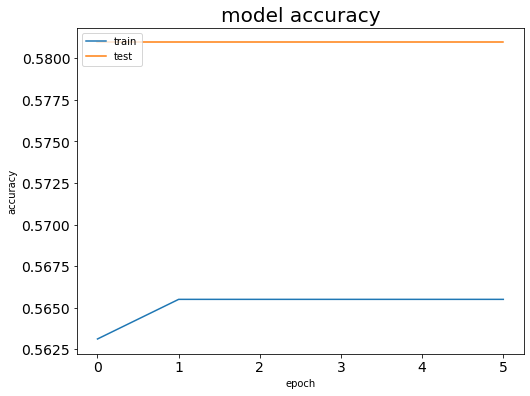

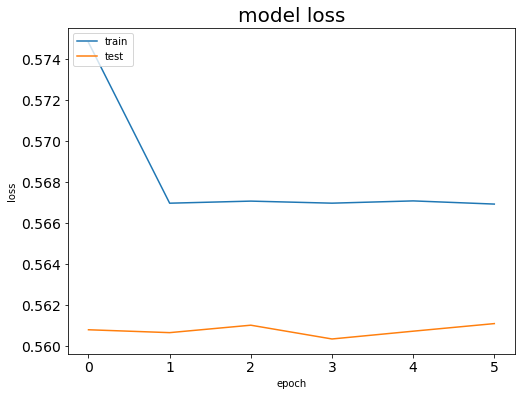

In [ ]:
plot_loss_accuracy_training(history)

Si obervamos las gráficas, el modelo no ha aprendido prácticamente nada, ya que la loss y la acc de validación a penas varía en las 5 epoch, una posible mejora podría ser la introducción de una capa adicional de Dropout.

## 4. Definición de modelos complejos 

Una vez definidas una serie de baselines, es momento de pasar a definir modelos más complejos. En este apartado se probarán modelos complejos, vistos durante las práticas, tales como:


*   Redes Convolucionales
*   Redes Recurrentes
*   Transformers

Se escogerá el modelo que mejor rendimiento tenga, para luego tratar de mejorar esos resultados con las técnicas que se considere oportunas.




### 4.1 Redes Convolucionales

En primer lugar se aplicará un modelo de Redes Convolucionales, contando con una capa de Embedding, una capa de Convolución y otra de MaxPooling, los parámetros seleccionados son los siguientes:


*   Filter: 3, se probó con filtros de mayor tamaño (32) pero los resultados fueron bastante malos, por lo que se probó con un filtro igual al número de neuronas de la capa de salida (3).
*   Kernel: 3, se selecciona una ventana de tamaño 3.
*   Padding: se utiliza padding por si hay desajustes a la hora de mover la ventana por el espacio de datos.
*   Pool size: 3, por ser el tamaño del filtro y del kernel.




In [15]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, Flatten
from keras.layers import Embedding, Flatten, Conv1D, MaxPooling1D

def create_cnn_embedding(conv_layers, filter, kernel, padding, pool_size, features):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=features, input_length=max_len))
    model.add(Conv1D(filters=filter, kernel_size=kernel, strides=1, padding=padding, input_shape=(max_len, features)))
    model.add(MaxPooling1D(pool_size=pool_size, strides=1, padding=padding))

    for _ in range(1, conv_layers):
      model.add(Conv1D(filters=filter, kernel_size=kernel, strides=1, padding=padding))
      model.add(MaxPooling1D(pool_size=pool_size, strides=1, padding=padding))

    model.add(Flatten())
    model.add(Dense(3))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    print(model.summary())
    return model

A continuación se puede observar la arquitectura del modelo, que cuenta con 265 mil parámetros.

In [16]:
neural_network_embedding = create_cnn_embedding(conv_layers=1, filter=3, kernel=3, padding='same', pool_size=3, features=100)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 512, 100)          259600    
                                                                 
 conv1d (Conv1D)             (None, 512, 3)            903       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 512, 3)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 3)                 4611      
                                                                 
Total params: 265,114
Trainable params: 265,114
Non-trainable params: 0
__________________________________________________

In [ ]:
history = neural_network_embedding.fit(nn_x_train, tensor_y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[early_stopping_loss, early_stopping_accuracy])

Epoch 1/40
197/197 [==============================] - 9s 41ms/step - loss: 1.3337 - accuracy: 0.4740 - val_loss: 0.5334 - val_accuracy: 0.5810
Epoch 2/40
197/197 [==============================] - 9s 44ms/step - loss: 0.4961 - accuracy: 0.6024 - val_loss: 0.5079 - val_accuracy: 0.6057
Epoch 3/40
197/197 [==============================] - 8s 41ms/step - loss: 0.4422 - accuracy: 0.6695 - val_loss: 0.5747 - val_accuracy: 0.5683
Epoch 4/40
197/197 [==============================] - 8s 40ms/step - loss: 0.4102 - accuracy: 0.7207 - val_loss: 0.7460 - val_accuracy: 0.5848
Epoch 5/40
197/197 [==============================] - 8s 40ms/step - loss: 0.4482 - accuracy: 0.7481 - val_loss: 1.1995 - val_accuracy: 0.5740
Epoch 6/40
197/197 [==============================] - 9s 46ms/step - loss: 0.3477 - accuracy: 0.7799 - val_loss: 0.9728 - val_accuracy: 0.5733
Epoch 7/40
197/197 [==============================] - 9s 43ms/step - loss: 0.3085 - accuracy: 0.8163 - val_loss: 1.2188 - val_accuracy: 0.5657

In [ ]:
evaluate_classifier(nn_x_test, encoded_y_train, neural_network_embedding)

              precision    recall  f1-score   support

           0       0.68      0.66      0.67      1139
           1       0.86      0.13      0.22      2257
           2       0.64      0.91      0.75      4476

    accuracy                           0.65      7872
   macro avg       0.72      0.57      0.55      7872
weighted avg       0.70      0.65      0.59      7872



Como se puede ver, los resultados son mejores que los del modelo baseline de Deep Learning, pero todavía no superan los conseguidos por RandomForest.
Es posible que pudieran superarlos, en caso de que se optimizaran los parámetros del modelo, para encontrar los más óptimos.

### 4.2 Redes Recurrentes

El siguiente modelo a probar es un modelo de Redes Recurrentes, para tratar de mejorar los resultados del modelo convolucional. La capa recurrente seleccionada es LSTM, ya que es la más completa. Anteriormente se probó con una capa GRU y los resultados eran ligeramente peores.

In [17]:
from keras import callbacks
from keras.layers import Embedding, LSTM

def create_rnn_embedding(features):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=features, input_length=max_len))
    model.add(LSTM(units=features))
    model.add(Dense(3, activation='sigmoid'))

    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
    print(model.summary())
    return model

A continuación se puede observar la arquitectura del modelo, que es ligeramente más pesado que el anterior con 340 mil parámetros, debido a que la capa de LSTM tiene mayor número de parámetros que la capa de convolución.

In [18]:
neural_network_embedding = create_rnn_embedding(features=100)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 512, 100)          259600    
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense_1 (Dense)             (None, 3)                 303       
                                                                 
Total params: 340,303
Trainable params: 340,303
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
history = neural_network_embedding.fit(nn_x_train, tensor_y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[early_stopping_loss, early_stopping_acc])

Epoch 1/40
197/197 [==============================] - 103s 499ms/step - loss: 0.5382 - acc: 0.5771 - val_loss: 0.4890 - val_acc: 0.5968
Epoch 2/40
197/197 [==============================] - 98s 498ms/step - loss: 0.4659 - acc: 0.6155 - val_loss: 0.4767 - val_acc: 0.6127
Epoch 3/40
197/197 [==============================] - 97s 493ms/step - loss: 0.4443 - acc: 0.6530 - val_loss: 0.4782 - val_acc: 0.6140
Epoch 4/40
197/197 [==============================] - 94s 479ms/step - loss: 0.5349 - acc: 0.6193 - val_loss: 0.4817 - val_acc: 0.6127
Epoch 5/40
197/197 [==============================] - 97s 491ms/step - loss: 0.4397 - acc: 0.6633 - val_loss: 0.4940 - val_acc: 0.6102
Epoch 6/40
197/197 [==============================] - 97s 494ms/step - loss: 0.4069 - acc: 0.6916 - val_loss: 0.5004 - val_acc: 0.5905
Epoch 7/40
197/197 [==============================] - 95s 481ms/step - loss: 0.3855 - acc: 0.7178 - val_loss: 0.4964 - val_acc: 0.5943


In [ ]:
evaluate_classifier(nn_x_test, encoded_y_train, neural_network_embedding)

              precision    recall  f1-score   support

           0       0.60      0.87      0.71      1139
           1       0.76      0.11      0.20      2257
           2       0.64      0.84      0.72      4476

    accuracy                           0.63      7872
   macro avg       0.66      0.61      0.54      7872
weighted avg       0.67      0.63      0.57      7872



En este caso, los resultados han sido muy parecidos al caso anterior, por lo que probablemente tampoco estén optimizados todos los parámetros del modelo. Una posible mejora podría ser probar a apilar varías capas recurrentes.

In [19]:
from keras import callbacks
from keras.layers import Embedding, GRU

def create_rnn_embedding(features):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=features, input_length=max_len))
    model.add(LSTM(units=features, return_sequences=True))
    model.add(LSTM(units=features))
    model.add(Dense(3, activation='sigmoid'))

    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
    print(model.summary())
    return model

Como se puede ver, este modelo aumenta todavía más el número de parámetros, por lo tanto también el tiempo de ejecución, a 420 mil parámetros.

In [20]:
neural_network_embedding = create_rnn_embedding(features=100)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 512, 100)          259600    
                                                                 
 lstm_1 (LSTM)               (None, 512, 100)          80400     
                                                                 
 lstm_2 (LSTM)               (None, 100)               80400     
                                                                 
 dense_2 (Dense)             (None, 3)                 303       
                                                                 
Total params: 420,703
Trainable params: 420,703
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
history = neural_network_embedding.fit(nn_x_train, tensor_y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[early_stopping_loss, early_stopping_acc])

Epoch 1/40
197/197 [==============================] - 248s 1s/step - loss: 0.5213 - acc: 0.5827 - val_loss: 0.4854 - val_acc: 0.6044
Epoch 2/40
197/197 [==============================] - 201s 1s/step - loss: 0.4658 - acc: 0.6112 - val_loss: 0.4818 - val_acc: 0.5810
Epoch 3/40
197/197 [==============================] - 195s 991ms/step - loss: 0.4871 - acc: 0.6103 - val_loss: 0.4848 - val_acc: 0.5937
Epoch 4/40
197/197 [==============================] - 200s 1s/step - loss: 0.4576 - acc: 0.6397 - val_loss: 0.5236 - val_acc: 0.5810
Epoch 5/40
197/197 [==============================] - 201s 1s/step - loss: 0.4289 - acc: 0.6700 - val_loss: 0.4796 - val_acc: 0.5816
Epoch 6/40
197/197 [==============================] - 206s 1s/step - loss: 0.3903 - acc: 0.7073 - val_loss: 0.4871 - val_acc: 0.5841


In [ ]:
evaluate_classifier(nn_x_test, encoded_y_train, neural_network_embedding)

              precision    recall  f1-score   support

           0       0.60      0.81      0.69      1139
           1       0.00      0.00      0.00      2257
           2       0.61      0.86      0.72      4476

    accuracy                           0.61      7872
   macro avg       0.40      0.56      0.47      7872
weighted avg       0.43      0.61      0.51      7872



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Después de aplicar las dos capas de LSTM, como se puede ver, empeoran los resultados, en este caso no se han clasificado datos en la clase 1. Esto puede ser debido a que el modelo finalmente discrimine entre las otras dos clases, posiblemente debido a la adición de la segunda capa de LSTM.

### 4.3. Transformers

Por último, se va a probar el último modelo, un transformer. Se seleccionará un modelo pre-entrenado de la librería huggingface, y se ajustará para esta tarea específica. 

Primero se instalan las librerías necesarias.

In [ ]:
import pandas as pd

!pip install datasets
import datasets
from torch.utils.data import DataLoader

# Transformers
!!pip install transformers[sentencepiece]
from transformers import AutoTokenizer, AutoModelForSequenceClassification

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 362 kB 17.6 MB/s 
     |████████████████████████████████| 1.1 MB 50.6 MB/s 
     |████████████████████████████████| 212 kB 56.7 MB/s 
     |████████████████████████████████| 140 kB 34.0 MB/s 
     |████████████████████████████████| 101 kB 5.8 MB/s 
     |████████████████████████████████| 596 kB 52.8 MB/s 
     |████████████████████████████████| 127 kB 43.3 MB/s 
     |████████████████████████████████| 144 kB 54.4 MB/s 
     |████████████████████████████████| 271 kB 56.7 MB/s 
     |████████████████████████████████| 94 kB 3.0 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
ERROR: pip's dep

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Es necesario cargar los datos con un objeto de tipo Dataset de la librería huggingface.

In [ ]:
base_url = "/content/drive/My Drive/"
dataset = datasets.load_dataset('csv', data_files={'train': base_url + 'sick_es_train.csv', 'test': base_url + 'sick_es_test.csv'})

Using custom data configuration default-28181699546a22f9


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-28181699546a22f9/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

La función `tokenize` tokeniza las frases, pasándolas como **dos frases distintas de una única secuencia** a diferencia de los modelos anteriores de Deep Learning, el modelo de transformers probablemente gestionará de mejor forma la entrada de 2 fraes. También gestiona las labels.

In [ ]:
def tokenize(dataset, tokenizer):
    labels = datasets.ClassLabel(num_classes=3, names=["CONTRADICTION", "NEUTRAL", "ENTAILMENT"])

    def tokenize_function(dataset):
        tokens = tokenizer(dataset["translated_A"], dataset["translated_B"], padding="max_length", truncation=True)
        tokens["labels"] = labels.str2int(dataset["entailment_label"])
        return tokens

    tokenized_datasets = dataset.map(tokenize_function, batched=True)
    tokenized_datasets = tokenized_datasets.remove_columns(["pair_ID"])
    tokenized_datasets = tokenized_datasets.remove_columns(["translated_A"])
    tokenized_datasets = tokenized_datasets.remove_columns(["translated_B"])    
    tokenized_datasets = tokenized_datasets.remove_columns(["entailment_label"])

    tokenized_datasets.set_format("torch")
    return tokenized_datasets

La función `data_loader` tokeniza los datasets y los transforma en DataLoaders de pyTorch para pasárselos al modelo de transformer.

In [ ]:
def data_loader(dataset, tokenizer, batch_size=16):
    tokenized_datasets = tokenize(dataset, tokenizer)

    train_dataset = tokenized_datasets["train"].shuffle(seed=42)
    eval_dataset = tokenized_datasets["test"].shuffle(seed=42)

    train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
    test_dataloader = DataLoader(eval_dataset, batch_size=batch_size)
    return train_dataloader, test_dataloader

Depués se cargan los parámteros del modelo en función `load_params`, donde se crea el optimizador, en este caso Adam, el número de pasos de entrenamiento, y el objeto de learning rate variable.

In [ ]:
from transformers import get_scheduler
from torch.optim import AdamW
import torch

epochs = 1

def load_params(model, train_dataloader):
    optimizer = AdamW(model.parameters(), lr=5e-5)
    num_training_steps = epochs * len(train_dataloader)
    lr_scheduler = get_scheduler(
        name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
    )
    return optimizer, num_training_steps, lr_scheduler

La función `train_model`, entrena el modelo con los parámetros escogidos en la función anterior, y realiza el bucle de entrenamiento.

In [ ]:
def train_model(model, num_training_steps, train_dataloader, optimizer, lr_scheduler):
    from tqdm.auto import tqdm

    progress_bar = tqdm(range(num_training_steps))

    model.train()
    for epoch in range(epochs):
        for batch in train_dataloader:
            batch = {k: v for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            loss.backward()

            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            progress_bar.update(1)

La función `evaluate_model`, realiza el bucle de evaluación, y computa las métricas utilizadas hasta ahora, accuracy, precisión, recall y f1.

In [ ]:
def evaluate_model(model, test_dataloader):
    from tqdm.auto import tqdm

    progress_bar = tqdm(range(len(test_dataloader)))

    accuracy = datasets.load_metric("accuracy")
    precision = datasets.load_metric("precision")
    recall = datasets.load_metric("recall")
    f1score = datasets.load_metric("f1")

    model.eval()
    for batch in test_dataloader:
        batch = {k: v for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)

        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)

        accuracy.add_batch(predictions=predictions, references=batch["labels"])
        precision.add_batch(predictions=predictions, references=batch["labels"])
        recall.add_batch(predictions=predictions, references=batch["labels"])
        f1score.add_batch(predictions=predictions, references=batch["labels"])

        progress_bar.update(1)

    print("Accuracy: ", accuracy.compute())
    print("Precision: ", precision.compute(average="weighted"))
    print("Recall: ", recall.compute(average="weighted"))
    print("F1score: ", f1score.compute(average="weighted"))

Ahora falta la selección del modelo preentrenado. Como se trata de una tarea bastante especifica, no he encontrado ningún modelo en castellano para poder utilizar, por lo que se ha escogido un modelo pequeño genérico en castellano, para no exceder los recusos de Google Colab. 

El modelo cuenta con 12 capas, embeddings de 256 dimensiones, y 22 millones de parémetros, lo que aumenta considerablemente el número de parámetros de los modelos anteriores.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("Recognai/selectra_small")
model = AutoModelForSequenceClassification.from_pretrained("Recognai/selectra_small", num_labels=3)

Downloading:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/378k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/85.8M [00:00<?, ?B/s]

Some weights of the model checkpoint at Recognai/selectra_small were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at Recognai/selectra_small and are newly initialized: ['classifier.out_proj.weight', 'cl

Para ver un ejemplo de como quedaría la secuencia de entrada, se prueba con una frase de dataset. Como se puede ver, se introducen las dos frases en un mismo dato, teniendolas en cuenta como dos frases separadas.

In [ ]:
tokenized_datasets = tokenize(dataset, tokenizer)
example = tokenized_datasets["train"][0]
tokenizer.decode(example["input_ids"])

'<s> Una mujer toca una flauta</s></s> La mujer no toca la flauta</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><

Creamos los dos DataLoader para entrenamiento y test, y cargamos los parámetros del modelo.

In [ ]:
train_dataloader, test_dataloader = data_loader(dataset, tokenizer)
optimizer, num_training_steps, lr_scheduler = load_params(model, train_dataloader)

  0%|          | 0/8 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

Entrenamos y evaluamos el modelo.

In [ ]:
train_model(model, num_training_steps, train_dataloader, optimizer, lr_scheduler)
torch.save(model, "/content/drive/My Drive/model1")

  0%|          | 0/492 [00:00<?, ?it/s]

In [ ]:
model = torch.load("/content/drive/My Drive/model1")
evaluate_model(model, test_dataloader)

  0%|          | 0/123 [00:00<?, ?it/s]

Accuracy:  {'accuracy': 0.8394308943089431}
Precision:  {'precision': 0.8417157558998376}
Recall:  {'recall': 0.8394308943089431}
F1score:  {'f1': 0.8401656276102903}


Como se ha podido observar, los resultados son mucho mejores que los obtenidos hasta ahora, co un 84% de accuracy y un 84% de f1. Posiblemente debido a que los modelos de transformers, como se ha ido viendo a lo largo de las prácticas de la asignatura, tienden a ser más completos y a aprovechar mejor el contexto de los datos. 

En este caso también se han procesado las frases por pares, de forma que las dos frases estaban separadas, cosa que no se ha hecho en los otros modelos de Deep Learning. A partir de ahora se tratarán de mejorar los resultados de este modelo.

## 5. Transfer Learning

Tras haber realizado pruebas con varios modelos, para el conjunto de entrenamiento y test, ahora se pretende valorar que tan bueno es el modelo aplicandolo a otros datos.

Para ello existe el Transfer Learning, ya utilizado en la práctica anterior, que se basa en evaluar el funcionamiento del modelo con datos no vistos anteriormente. Para ello contamos con los datos de AVE 2006, proporcionados en la práctica, también dedicados a la tarea de implicación textual.

### 5.1 Visualización de los datos de test

En primer lugar, como se hizo en el conjunto de datos anterior, es importante analizar los datos con los que se va a realizar esta nueva evaluación, y ver que diferencias puede tener con los datos originales.

In [ ]:
test_set = pd.read_csv("/content/drive/My Drive/AVE2006_test.csv", quotechar='"', header=0, sep=",")
test_set.head(10)

,id,text,hypothesis,value
0,1,atlantis - mir complicado acoplamiento parece ...,"El Atlantis es el transbordador espacial "" At...",YES
1,2122,El desacoplamiento de el transbordador espacia...,El Atlantis es transbordador espacial estadoun...,YES
2,4725,joven agraciado dijo que la película y el libr...,El Atlantis es STARGATE.,NO
3,6716,10.44 POX 94F.JPG MUN EXG POLITICA XA9728 643 ...,El Atlantis es IMPERIO PERDIDO.,NO
4,8671,20.31 CUL 94F.JPG MUN EXG CULTURA FB6640 191 R...,El Atlantis es ATLANTIS THE LOST EMPIRE.,NO
5,10617,"...Aunque la aproximación de las naves (11,27 ...",El Atlantis es transbordador estadounidense.,YES
6,15713,Pero la unión física de ambas naves estaba res...,El Atlantis es transbordador.,YES
7,16404,CADIZ ACOGE DESDE MAÑANA FORO MARITIMO ATLANTI...,El Atlantis es el Foro Marítimo.,YES
8,16604,Está planeado también una serie de experimento...,El Atlantis es las características dinámicas d...,NO
9,16804,"""...Aunque la aproximación de las naves (11,27...",El Atlantis es transbordador estadounidense.,YES


En este caso, los datos está formados por dos frases que estarán relacionadas o no, y a diferencia de los datos originales, aquí solo indica si hay implicación o no, mientras que en los otros datos indica también si existe neutralidad.

In [ ]:
not_implication_dataset = test_set[(test_set['value'] != 'YES') & (test_set['value'] != 'NO')]
print("Filas con un label incorrecto: ", not_implication_dataset.shape[0])

Filas con un label incorrecto:  0


Como se puede ver, existe un desbalance en los datos, así como en el caso anterior, donde la clase de "NO", es la más ocurrente.

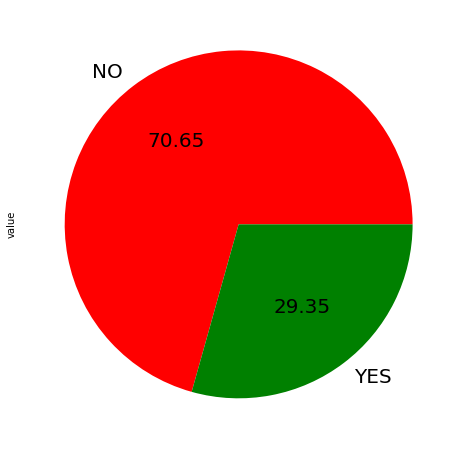

In [ ]:
test_set['value'].value_counts().plot(kind='pie', figsize=(10, 8), autopct='%.2f', fontsize=20, colors=['r', 'g'])

Si comparamos estos datos, con los datos originales, unificando las clases "CONTRADICTION" y "NEUTRAL" como "NO", y "ENTAILMENT" como "YES", obtenemos unos resultados casi idénticos. Por lo tanto no debería haber problema en cuanto a sesgos de desbalance de clases, ya que ambos datasets están desbalanceados por igual.

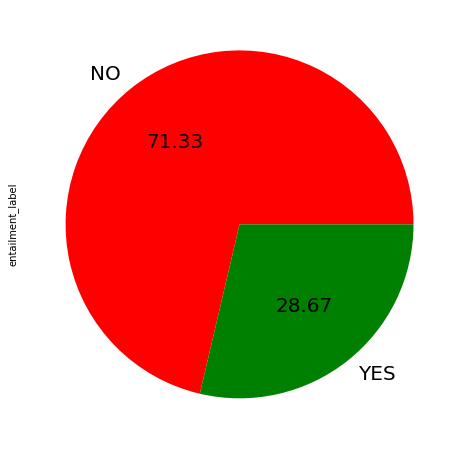

In [ ]:
original_training_set = pd.read_csv("/content/drive/My Drive/sick_es_train.csv", quotechar='"', header=0, sep=",")
original_test_set = pd.read_csv("/content/drive/My Drive/sick_es_test.csv", quotechar='"', header=0, sep=",")
original_dataset = pd.concat([original_training_set, original_test_set])

def replace(x):
    return x.replace("ENTAILMENT", "YES").replace("CONTRADICTION", "NO").replace("NEUTRAL", "NO")

original_dataset["entailment_label"] = original_dataset["entailment_label"].apply(replace)
original_dataset['entailment_label'].value_counts().plot(kind='pie', figsize=(10, 8), autopct='%.2f', fontsize=20, colors=['r', 'g'])

Para poder extraer las palabras más frecuentes, es necesario tokenizar las frases, como en el dataset original.

In [ ]:
test_set["text_processed"] = test_set["text"].apply(process_text)
test_set["hypothesis_processed"] = test_set["hypothesis"].apply(process_text)
test_set

,id,text,hypothesis,value,text_processed,hypothesis_processed
0,1,atlantis - mir complicado acoplamiento parece ...,"El Atlantis es el transbordador espacial "" At...",YES,"[atlantis, mir, complicado, acoplamiento, pare...","[atlantis, transbordador, espacial, atlantis]"
1,2122,El desacoplamiento de el transbordador espacia...,El Atlantis es transbordador espacial estadoun...,YES,"[desacoplamiento, transbordador, espacial, est...","[atlantis, transbordador, espacial, estadounid..."
2,4725,joven agraciado dijo que la película y el libr...,El Atlantis es STARGATE.,NO,"[joven, agraciado, dijo, pelicula, libro, star...","[atlantis, stargate]"
3,6716,10.44 POX 94F.JPG MUN EXG POLITICA XA9728 643 ...,El Atlantis es IMPERIO PERDIDO.,NO,"[10, 44, pox, 94f, jpg, mun, exg, politica, xa...","[atlantis, imperio, perdido]"
4,8671,20.31 CUL 94F.JPG MUN EXG CULTURA FB6640 191 R...,El Atlantis es ATLANTIS THE LOST EMPIRE.,NO,"[20, 31, cul, 94f, jpg, mun, exg, cultura, fb6...","[atlantis, atlantis, the, lost, empire]"
...,...,...,...,...,...,...
2281,15912,Este concepto se aplicó a la radicalización de...,Portugal es una república desde desde el 15 de...,NO,"[concepto, aplico, radicalizacion, revolucion,...","[portugal, republica, 15, mayo]"
2282,16112,Este concepto se aplicó a la radicalización de...,Portugal es una república desde 1974.,NO,"[concepto, aplico, radicalizacion, revolucion,...","[portugal, republica, 1974]"
2283,16603,- Se aprueba en el Congreso el dictamen refere...,Portugal es una república desde República de.,NO,"[aprueba, congreso, dictamen, referente, ingre...","[portugal, republica, republica]"
2284,16803,- Se aprueba en el Congreso el dictamen refere...,Portugal es una república desde República de.,NO,"[aprueba, congreso, dictamen, referente, ingre...","[portugal, republica, republica]"


In [ ]:
# Agrupación todos los tokens por clase
grouped_A = test_set.groupby("value").apply(lambda x: x["text_processed"].sum())
grouped_B = test_set.groupby("value").apply(lambda x: x["hypothesis_processed"].sum())
grouped_df = pd.DataFrame({"value": grouped_A.index, "text_processed": grouped_A.values, "hypothesis_processed": grouped_B.values})
grouped_df

,value,text_processed,hypothesis_processed
0,NO,"[joven, agraciado, dijo, pelicula, libro, star...","[atlantis, stargate, atlantis, imperio, perdid..."
1,YES,"[atlantis, mir, complicado, acoplamiento, pare...","[atlantis, transbordador, espacial, atlantis, ..."


En este caso se van a representar las palabras más frecuentes en la clase "NO", equivalente a las clases "CONTRADICTION" y "NEUTRAL".

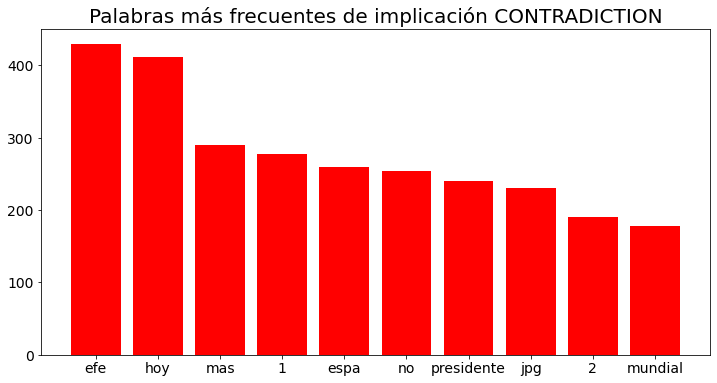

In [ ]:
contradiction_tokens = grouped_df[grouped_df['value'] == 'NO']['text_processed'].values.tolist()[0] \
                     + grouped_df[grouped_df['value'] == 'NO']['hypothesis_processed'].values.tolist()[0]
plot_most_frequent_words(contradiction_tokens, 'CONTRADICTION')

En este caso no parece que tengan mucha reelenvancia palabras que contengan mucho significado, las palabras más relevantes podrían ser "presidente" y "mundial".

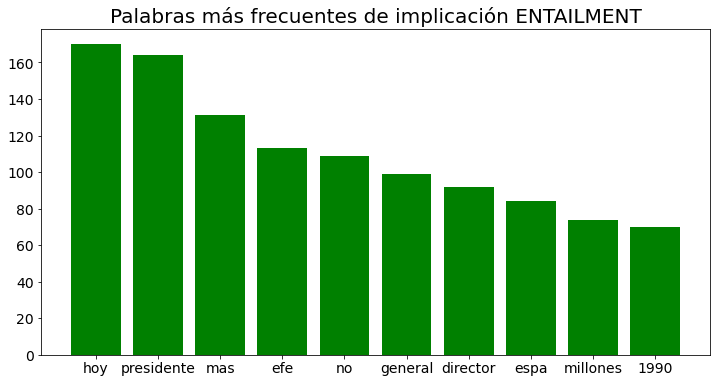

In [ ]:
contradiction_tokens = grouped_df[grouped_df['value'] == 'YES']['text_processed'].values.tolist()[0] \
                     + grouped_df[grouped_df['value'] == 'YES']['hypothesis_processed'].values.tolist()[0]
plot_most_frequent_words(contradiction_tokens, 'ENTAILMENT')

Para el caso de las frases con implicación, parece que hay más enfasis en palabras como "presidente", "general", "director", y "millones", lo que podría estar relacionado con el hecho de relacionar altos cargos con algún evento, con motivos económicos o fechas concretas, como "millones", o "1990".

Las palabras "hoy", "efe" y "no" no parecen marcar ninguna diferencia entre ambas clases.

### 5.2 Preparación del modelo para el testeo 

Para realizar la prueba, en primer lugar se utilizará el modelo de transformer, previamente entrenado. Con ello existe un problema, este modelo ha sido entrenado con 3 clases "CONTRADICTION", "NEUTRAL" y "ENTAILMENT", por lo tanto habrá que unificar dos clases en una, volver a entrenar el modelo y después, realizar la evaluación con el nuevo dataset.

Para ello volvemos a cargar el modelo pre-entrenado, esta vez para clasificar con 2 clases.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("Recognai/selectra_small")
model = AutoModelForSequenceClassification.from_pretrained("Recognai/selectra_small", num_labels=2)

Some weights of the model checkpoint at Recognai/selectra_small were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at Recognai/selectra_small and are newly initialized: ['classifier.out_proj.weight', 'cl

También es necesario reemplazar las clases "NEUTRAL" y "CONTRADICTION" por la nueva clase "NO ENTAILMENT" (equivalente a "NO"). Y volver a tokenizar el dataset con estas características.

In [ ]:
def tokenize(dataset, tokenizer):
    labels = datasets.ClassLabel(num_classes=2, names=["NO ENTAILMENT", "ENTAILMENT"])

    def tokenize_function(dataset):
        dataset["entailment_label"] = ["NO ENTAILMENT" if item in ("NEUTRAL", "CONTRADICTION") else item for item in dataset["entailment_label"]]
        tokens = tokenizer(dataset["translated_A"], dataset["translated_B"], padding="max_length", truncation=True)
        tokens["labels"] = labels.str2int(dataset["entailment_label"])
        return tokens

    tokenized_datasets = dataset.map(tokenize_function, batched=True)
    tokenized_datasets = tokenized_datasets.remove_columns(["pair_ID"])
    tokenized_datasets = tokenized_datasets.remove_columns(["translated_A"])
    tokenized_datasets = tokenized_datasets.remove_columns(["translated_B"])    
    tokenized_datasets = tokenized_datasets.remove_columns(["entailment_label"])

    tokenized_datasets.set_format("torch")
    return tokenized_datasets

Se cargan los datos y los parámetros del modelo.

In [ ]:
train_dataloader, test_dataloader = data_loader(dataset, tokenizer)
optimizer, num_training_steps, lr_scheduler = load_params(model, train_dataloader)

  0%|          | 0/8 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

Se entrena el modelo.

In [ ]:
train_model(model, num_training_steps, train_dataloader, optimizer, lr_scheduler)
torch.save(model, "/content/drive/My Drive/model1bis")

  0%|          | 0/492 [00:00<?, ?it/s]

Se realiza la evaluación. En este caso podemos comparar estos resultados con el mismo modelo entrenado para las 3 clases originales.

In [ ]:
model = torch.load("/content/drive/My Drive/model1bis")
evaluate_model(model, test_dataloader)

  0%|          | 0/123 [00:00<?, ?it/s]

Accuracy:  {'accuracy': 0.8790650406504065}
Precision:  {'precision': 0.8813500682975599}
Recall:  {'recall': 0.8790650406504065}
F1score:  {'f1': 0.8799785591271237}


Como se observa en los resultados, entrenando el modelo con dos clases, se obtiene unos resultados de 88% de accuracy y 88% de F1, los máximos obtenidos hasta el momento, a diferencia del modelo con las 3 clases originales, con un 84% de accuracy y 84% de F1.

Esto puede ser debido a que cuantas menos clases existan para clasificar los datos, menor probabilidad de error hay, ya que a priori hay un 50% de probabilidades de escoger bien la clase, lo que hace más sencilla la tarea del clasificador.

### 5.3 Preparación de los datos de testeo para el Transfer Learning

Una vez entrenado el nuevo modelo con 2 clases, es necesario preparar los nuevos datos para poder ser evaluados. Cargandolos, y tokenizandolos.

In [ ]:
base_url = "/content/drive/My Drive/"
dataset_test = datasets.load_dataset('csv', data_files={'test': base_url + 'AVE2006_test.csv'})

Using custom data configuration default-dd324e6aae0d4198
Reusing dataset csv (/root/.cache/huggingface/datasets/csv/default-dd324e6aae0d4198/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58)


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
def tokenize(dataset, tokenizer):
    labels = datasets.ClassLabel(num_classes=2, names=["NO", "YES"])

    def tokenize_function(dataset):
        tokens = tokenizer(dataset["text"], dataset["hypothesis"], padding="max_length", truncation=True)
        tokens["labels"] = labels.str2int(dataset["value"])
        return tokens

    tokenized_datasets = dataset.map(tokenize_function, batched=True)
    tokenized_datasets = tokenized_datasets.remove_columns(["id"])
    tokenized_datasets = tokenized_datasets.remove_columns(["text"])
    tokenized_datasets = tokenized_datasets.remove_columns(["hypothesis"])    
    tokenized_datasets = tokenized_datasets.remove_columns(["value"])

    tokenized_datasets.set_format("torch")
    return tokenized_datasets

Creamos el objeto de DataLoader para poder pasarselo al modelo.

In [ ]:
tokenized_test = tokenize(dataset_test, tokenizer)
eval_dataset = tokenized_test["test"].shuffle(seed=42)
test_dataloader = DataLoader(eval_dataset, batch_size=16)

  0%|          | 0/3 [00:00<?, ?ba/s]

Evaluamos el modelo con el dataset AVE 2006.

In [ ]:
evaluate_model(model, test_dataloader)

  0%|          | 0/143 [00:00<?, ?it/s]

Accuracy:  {'accuracy': 0.7025371828521435}
Precision:  {'precision': 0.6298316106184008}
Recall:  {'recall': 0.7025371828521435}
F1score:  {'f1': 0.6049075969267312}


Se han obtenido unos resultados relativamente buenos, teniendo en cuenta que es un dataset completamente distinto al dataset con el cual se entrenó el modelo, con una accuracy del 70%, y un F1 del 60%.

Otra posible causa de estos resultados no tan buenos puede ser el desbalance de clases, que a pesar de ser el mismo porcenteje, puede afectar, al ser datos de naturaleza distinta. Esto se tratará en la siguiente sección.

## 6. Posibles mejoras para el modelo

Uno de los posibles cuellos de botella que presentan los datos, es el hecho de estar tan desbalanceado, hemos observado que el modelo funciona mejor cuando sólo existen dos clases, pero aun así existe este desbalance tan marcado. 

Existen varias formas de hacer frente a este problema:

* La primera de ellas es añadir pesos a las clases, donde las clases menor representadas tendrán más peso que las más representadas.
* La segunda es realizar Data Augmentation, una técnica para aumentar atificialmente la cantidad de datos de la clase minoritaria, para así balancear el dataset.

En esta ocasión, al tratarse de mejorar el modelo de transformer, se ha optado por realizar Data Augmentation, para aprovechar que se trata de un modelo que aprovecha las características semánticas de los datos.
Se puede realizar un aumento de los datos a nivel de frases, o a nivel de palabras.

### 6.1 Data Augmentatio a nivel de frase

En primer lugar se probará a relizar los aumentos a nivel de frase, con la librería NLPAug.

In [ ]:
!pip install nlpaug
import nlpaug.augmenter.sentence as nas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 410 kB 4.3 MB/s 


Antes de nada, se van a realizar unas pruebas para ver como funciona el aumento de datos, primero se va utilizar la clase ContextualWordEmbsForSentenceAug, que se basa en cargar un modelo de transformer generador (en nuestro caso gpt2), para generar una nueva frase parecida a la original.

In [ ]:
# aug = nas.ContextualWordEmbsForSentenceAug(model_path='datificate/gpt2-small-spanish')
# aug = nas.ContextualWordEmbsForSentenceAug(model_path='PlanTL-GOB-ES/gpt2-base-bne')
# aug = nas.ContextualWordEmbsForSentenceAug(model_path='DeepESP/gpt2-spanish-medium')
# aug = nas.ContextualWordEmbsForSentenceAug(model_path='mrm8488/spanish-gpt2')
aug = nas.ContextualWordEmbsForSentenceAug(model_path='Amloii/gpt2-reviewspanish')

In [ ]:
text = "Una mujer toca una flauta por que está triste, pero al final ha dejado de tocar la flauta por este motivo"
augmented_text = aug.augment(text, n=1, num_thread=-1)
augmented_text

En este caso se han probado varios modelos gpt2 en castellano, pero parece que los resultados son bastante malos, por lo que se va a probar con otra funcionalidad de la librería. La clase AbstSummAug genera un resumen de la frase original (summarization).

In [ ]:
# aug = nas.AbstSummAug(model_path='google/mt5-base', force_reload=True)
# aug = nas.AbstSummAug(model_path='josmunpen/mt5-small-spanish-summarization', force_reload=True)
aug = nas.AbstSummAug(model_path='flax-community/spanish-t5-small', force_reload=True)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
text = "Una mujer toca una flauta por que está triste, pero al final ha dejado de tocar la flauta por este motivo"
augmented_text = aug.augment(text, n=1, num_thread=-1)
augmented_text

'Una mujer toca una flauta por que está triste, pero al final ha dejado de tocar la flauta por este motivo'

En este caso parece ser que deja la frase tal y como estaba, por lo que no resulta util para aumentar los datos con frases similares.

### 6.2 Data Augmentatio a nivel de palabra

Debido a que no es factible utilizar el aumento de datos a nivel de frase, se va a probar a realizar el aumento a nivel de palabra, en concreto, aplicando la técnica de Back Translation, la cual consiste en traducir la frase a un idioma (en este caso inglés) y volver a traducirla al idioma original, para así variar ciertas palabras, pero no el significado.

In [ ]:
!pip install nlpaug
!pip install sacremoses
import nlpaug.augmenter.word as naw

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 410 kB 8.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 880 kB 4.7 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=ed29fc82d157f20ae09446ff768846bf09a8bae4827c7f73afd8ff3a181e3193
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses


Se cargan los modelos de traducción español / inglés.

In [ ]:
aug = naw.BackTranslationAug(from_model_name="Helsinki-NLP/opus-mt-es-en", to_model_name="Helsinki-NLP/opus-mt-en-es")

Downloading:   0%|          | 0.00/1.16k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/298M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.31k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/298M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/807k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/783k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.52M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/783k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/807k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.52M [00:00<?, ?B/s]

Se prueba con una frase, y como se puede observar, ha variado el léxico de la frase, pero no su significado, por lo que es factible utilizar esta técnica.

In [ ]:
text = "Me tomo muchos medicamentos en mi dia a dia"
augmented_text = aug.augment(text, n=1, num_thread=-1)
augmented_text

'Tomo mucha medicina en mi día a día.'

Ahora faltaría seleccionar los datos de la clase minoritaria "ENTAILMENT" y aplicarle el Back Translation, en este caso, aumentaremos una frase para cada frase original, por lo que se duplicará el tamaño de la clase "ENTAILMENT".

In [ ]:
entailment_dataset = dataset["train"].filter(lambda example: example["entailment_label"] == "ENTAILMENT")
entailment_dataset

  0%|          | 0/8 [00:00<?, ?ba/s]

Dataset({
    features: ['pair_ID', 'translated_A', 'translated_B', 'entailment_label'],
    num_rows: 2257
})

In [ ]:
augmented_sequences_A = aug.augment(entailment_dataset["translated_A"], n=1, num_thread=-1)
augmented_sequences_B = aug.augment(entailment_dataset["translated_B"], n=1, num_thread=-1) 

In [ ]:
def augment_data(original_data, sent_A, sent_B):
    row = {"pair_ID": [-1] * len(sent_A), "translated_A": sent_A, "translated_B": sent_B, "entailment_label": ["ENTAILMENT"] * len(sent_A)}
    data = datasets.Dataset.from_dict(row)
    original_data = datasets.concatenate_datasets([original_data, data])          
    return original_data

Una vez generado las frases artificiales, las concatenamos al dataset original y ya tendríamos los datos listos para entrenar el modelo.

In [ ]:
augmented_dataset = augment_data(dataset["train"], augmented_sequences_A, augmented_sequences_B)
augmented_dataset.save_to_disk("/content/drive/My Drive/augmented_dataset")

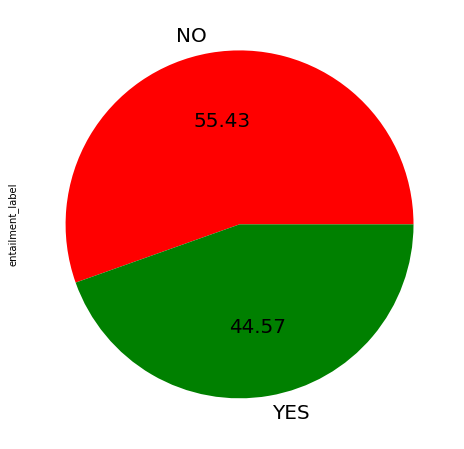

In [ ]:
def replace(x):
    return x.replace("ENTAILMENT", "YES").replace("CONTRADICTION", "NO").replace("NEUTRAL", "NO")

data = pd.DataFrame(augmented_dataset)
data["entailment_label"] = data["entailment_label"].apply(replace)
data['entailment_label'].value_counts().plot(kind='pie', figsize=(10, 8), autopct='%.2f', fontsize=20, colors=['r', 'g'])

La nueva proporción de datos quedaría bastante igualada, casí la mitad de datos de cada clase, lo que en teoría se debería traducir en una mejora de los resultados.

### 6.3 Entrenamiento y evaluación del modelo con datos aumentados

Una vez tenemos los datos, volvemos a cargar el modelo para entrenarlo, y lo entrenaremos con los datos aumentados.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("Recognai/selectra_small")
model = AutoModelForSequenceClassification.from_pretrained("Recognai/selectra_small", num_labels=2)

Downloading:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/378k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/85.8M [00:00<?, ?B/s]

Some weights of the model checkpoint at Recognai/selectra_small were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at Recognai/selectra_small and are newly initialized: ['classifier.dense.bias', 'classif

In [ ]:
augmented_dataset = datasets.load_from_disk("/content/drive/My Drive/augmented_dataset")

tokenized_aug = tokenize(augmented_dataset, tokenizer)
train_dataset = tokenized_aug.shuffle(seed=42)
train_dataloader = DataLoader(train_dataset, batch_size=16)

  0%|          | 0/11 [00:00<?, ?ba/s]

Se entrena el modelo.

In [ ]:
optimizer, num_training_steps, lr_scheduler = load_params(model, train_dataloader)
train_model(model, num_training_steps, train_dataloader, optimizer, lr_scheduler)
torch.save(model, "/content/drive/My Drive/model1augmented")

  0%|          | 0/634 [00:00<?, ?it/s]

Se evalúa el modelo.

In [ ]:
model = torch.load("/content/drive/My Drive/model1augmented")
tokenized_data = tokenize(dataset["test"], tokenizer)
test_dataset = tokenized_data.shuffle(seed=42)
test_dataloader = DataLoader(test_dataset, batch_size=16)
evaluate_model(model, test_dataloader)

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/123 [00:00<?, ?it/s]

Accuracy:  {'accuracy': 0.8414634146341463}
Precision:  {'precision': 0.8763744181036404}
Recall:  {'recall': 0.8414634146341463}
F1score:  {'f1': 0.8477560332091999}


Como se puede observar, los resultados han empeorado ligeramente frente al entrenamiento anterior (utilizando 2 clases) y son ligeramente mejores que los obtenidos con el dataset original con 3 clases.

Esto puede ser debido a que las frases generadas hayan podido generar algo de ruido en los datos, que haya podido empeorar un poco los resultados, aun así, no son malos resultados, ya que en han seguido siendo mejores que los obtenidos con el modelo de 3 clases, por lo que podrían explorarse otros ajustes de Data Augmentatio, añadiendo mayor o menor número de frases, o probando a realizarlo con las 3 clases en lugar de con 2.


#### 6.3.1 Evaluación del dataset AVE 2006 con el modelo

Para finalizar, se va a probar el modelo con los datos de prueba de AVE, para ver como cambian los resultados después del aumento de datos.

In [ ]:
base_url = "/content/drive/My Drive/"
dataset_test = datasets.load_dataset('csv', data_files={'test': base_url + 'AVE2006_test.csv'})
tokenized_test = tokenize(dataset_test, tokenizer)
eval_dataset = tokenized_test["test"].shuffle(seed=42)
test_dataloader = DataLoader(eval_dataset, batch_size=16)
evaluate_model(model, test_dataloader)

Using custom data configuration default-dd324e6aae0d4198
Reusing dataset csv (/root/.cache/huggingface/datasets/csv/default-dd324e6aae0d4198/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/143 [00:00<?, ?it/s]

Accuracy:  {'accuracy': 0.6732283464566929}
Precision:  {'precision': 0.6479549247403573}
Recall:  {'recall': 0.6732283464566929}
F1score:  {'f1': 0.6564263250407602}


Los resultados han mejorado respecto al caso anterior, con un 67% de accuracy, y un 65%. Es accuracy ha bajado ligeramente, pero el f1 ha subido un 5%. La mejora puede haberse debido a que el modelo tiene mayor generalización de los datos de cada clase, por lo que ha mejorado la precisión, sacrificando algo de recall. 

Como en el caso anterior, sería interesante ver como varían estos resultados realizando más pruebas con el aumento de datos, o incluso aplicando otras técnicas como por ejemplo añadir sinónimos y antónimos.

## 7. Conclusiones

Durante todo el curso se han ido explorando diversos modelos para la tarea se Sentiment Analysis, y se han ido varlorando los resultados obtenidos para distintas arquitecturas, de más simples a más complejas. 

En esta práctica se ha hecho algo similar, para una tarea de Textual Implication, en esta ocasión con datos que en lugar de ser una frase, eran dos, lo que cambia significativamente los resultados de los modelos probados.

Lo que se puede observar, es que es importante realizar una buena fase de extración de características si se quiere utilizar modelos clásicos (con un modelo Word Embedding mejor entrenado, y con datos sintácticos parecidos a los datos), pero que también los modelos de Deep Learning pueden no ser la mejor opción en algunos casos. También se puede ver los buenos resultados que da un modelo de transformer.

Respecto a la eficiencia del modelo, si se hace una análisis sobre el tiempo de entrenamiento / parámetros vs resultados obtenidos, observamos que el número de parámetros a gran escala puede influir en los resultados, ya que el modelo con 
mayores resultados tiene casi 40 veces más parámetros que el resto. 

*   CNN -------------- 265 mil parámetros -------------- 55% F1
*   LSTM ------------ 340 mil parámetros -------------- 54% F1
*   LSTM x2 ------- 420 mil parámteros -------------- 47% F1
*   Transformer -- 2 mill parámetros ----------------- 88% F1

Sin embargo, si nos fijamos entre las diferencias en los 3 modelos de redes neuronales, la diferencia de parámetros no parce mejorar, por lo que entrará más en juego el tipo de capa que sea, y como de bien funcione con los datos del modelo.

Otra observarción es que los modelos de transformer parece que se adaptan bastante bien a los cambios en los datos, ya que al evaluar el modelo con el dataset del AVE, se han obtenido resultados bastante buenos, y probablemente serían mejorables, realizando por ejemplo, Data Augmentation con mayor diversidad de técnicas.

En conclusión, es importante probar varios modelos en cada caso, ya que los datos, y como estos se procesen, va a tener relación directa con los resultados obtenidos. También se podría haber probado con arquitecturas más complejas de DL, o tratando de introducir los datos de otra forma, en lugar de utilizar la capa de Embedding.


